##**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

##**Aprendizaje Automático Profundo (Deep Learning)**

*Edición 2022*


**Integrantes:**


M Mercedes Silva

Williams Gremoliche


----



## Ejercicio:
Implementar una red neuronal que asigne una categoría dado un título.
Para este práctico se puede usar cualquier tipo de red neuronal. Les que hagan solo la primera mitad de la materia,
implementarán un MLP. Quienes cursan la materia completa, deberían implementar algo más complejo, usando CNNs,
RNNs o Transformers.

Algunas consideraciones a tener en cuenta para estructurar el trabajo:



1.   Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
2.   Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
3.   Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
4.   Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
5.   Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
6.   Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy (Macro-recall).

In [2]:
#010 Importacion de librerias
import gzip
import mlflow
import pandas as pd
import tempfile
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset
import json
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import bz2

#import spacy
#from spacy.lang.es.examples import sentences

from gensim import corpora
from gensim.parsing import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import balanced_accuracy_score, recall_score

from tqdm.notebook import tqdm, trange
from datetime import datetime as dt

import gc

nltk.download("stopwords")

tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/wgremoliche/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#ya lo bajamos
# Descargamos los datasets
#!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
#!tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/

##Descarga de datos Meli Challenge 2019

In [4]:
#020 Descarga de datos
for i in trange(3):
    df_train = pd.read_json(
        './data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True)
    df_validation = pd.read_json(
        './data/meli-challenge-2019/spanish.validation.jsonl.gz',lines=True)
    df_test = pd.read_json(
        './data/meli-challenge-2019/spanish.test.jsonl.gz',lines=True)

len(df_train), len(df_validation), len(df_test)

  0%|          | 0/3 [00:00<?, ?it/s]

(4895280, 1223820, 63680)

In [5]:
#030 train_test_split

use_sampler = True
if use_sampler:
    df_train = shuffle(df_train, random_state=0)
    data_train, df = train_test_split(df_train, train_size = 0.10, random_state = 0, stratify = df_train.category)
    df_validation = shuffle(df_validation, random_state=0)
    data_validation, df =  train_test_split(df_validation, train_size = 0.10, random_state = 0, stratify = df_validation.category)
    data_train_val = pd.concat([data_train, data_validation], ignore_index=True)[['title','category','split']]
    train_size, validation_size, test_size = len(data_train), len(data_validation), len(df_test)
    print(f'Train: {train_size} - Validation: {validation_size} - Test: {test_size}')
else:    
    data_train_val = pd.concat([df_train, df_validation], ignore_index=True)[['title','category','split']]
    train_size, validation_size, test_size = len(df_train), len(df_validation), len(df_test)
    print(f'Train: {train_size} - Validation: {validation_size} - Test: {test_size}')


Train: 489528 - Validation: 122382 - Test: 63680


In [6]:
#040 liberamos memoria
del df
del df_train
del df_validation
del df_test # después lo cargamos de nuevo al momento de probar el modelo final

In [7]:
# Descargamos word embeddings, lo corremos una vez
#!curl -L https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -o ./data/SBW-vectors-300-min5.txt.bz2

## Dataset
Se crearon dos clases dataset, una para levantar todos los datos del lote y otra que lo hace en forma iterable

In [8]:
#050 creacion del dataset
class MeLiChallengeDataset(Dataset):
    def __init__(self, path, transform=None):
#         self.dataset = pd.read_json(path, lines=True)
        self.dataset = path
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()  # Deal with list of items instead of tensor
        
        item = {
            'data': self.dataset.iloc[item]['title'],
            'target': self.dataset.iloc[item]['category']
        }

        if self.transform:
            item = self.transform(item)
        
        return item

In [9]:
#060 creacion del dataset para iterar

class MeLiChallengeiterDataset(IterableDataset):
    def __init__(self, path, transform=None):
        self.dataset_path = path
        self.transform = transform

    def __iter__(self):
        with gzip.open(self.dataset_path, "rt") as fh:
            for l in fh:
                data = json.loads(l)
                item = {
                    "data": data['title'],
                    "target": data['category']
                }
                
                if self.transform:
                    yield self.transform(item)
                else:
                    yield item


Dados los tiempos y el poder de procesamiento disponible utilizaremos 10% datos de los 4895280 disponibles.
Se estima que aumentando este valor se mejorarian las metricas de los modelos propuestos.

El set de datos tiene 10 columnas, estas son:

**language:** Lenguaje

**label_quality:** calidad de etiqueta

**title:** titulo

**category:** categoría

**split:** train, test, etc

**tokenized_title:** titulo separado palabra por palabra

**data:** tokenized_title convertido a numeración

**target:** variable objetivo

**n_labels:** número de etiquetas posibles

**size:** tamaño




El set de entrenamiento original tiene 4895280 registros con valores no nulos y 10 columnas.

Las columnas son: language: El idioma del dataset (españor o portugués). En el trabajo práctico utilizaremos solamente el dataset es español. label_quality: Calidad de la etiqueta (confiable o no confiable). Se dispone de 4508043 registros no confiables y 387237 registros confiables. title: El título que se asignó al producto. category: La categoría que se asignó al producto. split: El tipo de dataset. train para el set de entrenamiento. tokenized_title: El título tokenizado. Esto significa que los datos fueron preprocesados. data: El número asignado a cada palabra del título tokenizado. Esta información es la que se utilizará para entrenar el modelo. target: El número que corresponde a cada categoría. n_labels: Cantidad de etiquetas numéricas correspondientes a las distintas categorías. 632 etiquetas (0 a 631) para el caso del set de entrenamiento. size: La cantidad de registros. 4895280 registros para el caso del set de entrenamiento.

El set de prueba original tiene 63680 registros con valores no nulos y 10 columnas.

Las columnas son iguales: Difieren en: split: El tipo de dataset. test para el set de prueba. size: La cantidad de registros. 63680 registros para el caso del set de prueba.

El set de validación original tiene 1223820 registros con valores no nulos y 10 columnas.

Las columnas son iguales.

El archivo spanish_token_to_index tiene las 50002 correspondencias que existen entre las palabras tokenizadas del título y las etiquetas numéricas bajo la columna data en los sets de entrenamiento, prueba y validación.

## Preprocesamiento
Vamos a transformar los datos, se va a preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings y así permitir mayor manipulación de los embeddings



---

El preprocesamiento de los títulos se realizó utilizando las librerías Gensim y NLTK. Las tareas se ejecutan en el siguiente orden:

Transformar todas las cadenas en minúsculas
Eliminar etiquetas de código del tipo ,
Separar por un espacio de cadenas alfanuméricas
Reemplazar signos de puntuación ASCII por espacios
Eliminar cualquier otro caracter que no sea letras o númemros
Remover espacios múltiples
Eliminar dígitos numéricos
Descartar las cadenas de longitud menor a 3
Una vez generado el diccionario de palabras, se eliminan de este las palabras vacías (o stopwords) del listado predefinido para español en la librería NLTK. Esto es para propiciar que en diccionario aparezcan palabras que puedan aportar información relevante. Luego, se incluyen dos tokens especiales. Uno para las palabras desconocidas (1) y otro para el relleno al ajustar el tamaño de las cadenas (0). Por último, se codifican las categorías con un índice, por orden de aparición. En este caso se cuenta con 632 categrías diferentes.


---



In [10]:
#070
es_stopwords = stopwords.words("spanish")

In [11]:
#080 Preprocesamiento
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )

         # Filter the dictionary with extremos words
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)

        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        # self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
                
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0, #The padding token
            "[UNK]": 1  # The unknown token
        })

        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _remove_stopwords(self, wdlist):
        # incorporamos una funcion para extraer las stopwords en espanol
        return [word for word in wdlist if word not in es_stopwords]

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._remove_stopwords(self._preprocess_string(data)))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [12]:
#090 
preprocess = RawDataProcessor(data_train_val)


In [13]:
#100

use_iterableDataset = False

if use_iterableDataset:
    train_dataset = MeLiChallengeiterDataset("./data/meli-challenge-2019/spanish.train.jsonl.gz", transform=preprocess)
    val_dataset = MeLiChallengeiterDataset("./data/meli-challenge-2019/spanish.validation.jsonl.gz", transform=preprocess)
else:
    train_dataset = MeLiChallengeDataset(data_train_val[data_train_val.split == 'train'], transform=preprocess)
    val_dataset = MeLiChallengeDataset(data_train_val[data_train_val.split == 'validation'], transform=preprocess)


In [14]:
#110 Se creó una clase PadSequences para igualar el tamaño de los datos con los que será alimentada la red
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

Como trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un batch de datos, el DataLoader de PyTorch espera que los datos del batch tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija).  Se define un módulo PadSequences que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (pad) y dada una lista de secuencias, devuelve un tensor con padding sobre dichas secuencias.

Ya habiendo definido nuestros conjuntos de datos y nuestra PadSequences, podemos definir nuestros DataLoader, uno para entrenamiento y otro para evaluación. Ver que la diferencia fundamental está en shuffle, no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante mini-batchs nos puede generar inconsistencias.

In [15]:
#120 se usaron los dataloaders de Pytorch para pasar los datos por lotes

pad_sequences = PadSequences()
batch_size = 128

if use_iterableDataset:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=pad_sequences, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=pad_sequences, drop_last=False)


Modelo baseline
Se diseñó un modelo simple con una capa de embeding, dos capas ocultas con función de activación relu y la capa de salida. La función de pérdida utilizada para todo el trabajo fue CrossEntropyLoss, apropiada para problemas de clasificación muticlase. Además, se optó por utiilizar Adam como algoritmo de optimización. Por una cuestión de capacidad de procesamiento todos los modelos fueron entrenados en 4 épocas

In [16]:
#130 
class MLPBaseTitleClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, 256)
        self.hidden_layer2 = nn.Linear(256, 1264)
        self.output_layer = nn.Linear(1264, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        x = self.output_layer(x) # use of CrossEntropyLoss() equivalent to the combination of LogSoftmax and NLLLoss.
        return x

In [17]:
#140
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
#150

EPOCHS = 5
BATCHES_t = (int(train_size/batch_size) + (train_size % batch_size>0))
BATCHES_v = (int(validation_size/batch_size) + (validation_size % batch_size>0))

model = MLPBaseTitleClassifier(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess.dictionary,
                        vector_size=300,
                        freeze_embedings=True)



loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in trange(EPOCHS):
    model.to(device)
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, total=BATCHES_t)
    for idx, batch in enumerate(pbar):
        data = batch["data"].to(device)
        target = batch["target"].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_value = loss_function(output, target)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
            pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
            running_loss = 0.0

    model.eval()
    targets = []
    predictions = []
    running_loss = 0
    pbar = tqdm(val_loader, total=BATCHES_v)
    with torch.no_grad():
        for idx, batch in enumerate(pbar):
            # get the input
            data = batch["data"].to(device)
            target = batch["target"].to(device)  
            output = model(data)
            loss_value = loss_function(output, target)
            targets.extend(target.cpu().numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            running_loss += loss_value.item()
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        metric = balanced_accuracy_score(targets, predictions)
        
    print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.49338077561891114


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5815275315111349


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6179914076079343


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.643333488011365


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6562527173434473


Ajuste de Hiperparametros

In [19]:
#ajuste de hiperparametros
class MLPTitleClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings,
                 activation_fn,
                 neurons_h1,
                 neurons_h2,
                 p_dropout):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, neurons_h1)
        self.hidden_layer1_dp = nn.Dropout(p=p_dropout)
        self.hidden_layer2 = nn.Linear(neurons_h1, neurons_h2)
        self.hidden_layer2_dp = nn.Dropout(p=p_dropout)
        self.output_layer = nn.Linear(neurons_h2, 632)
        self.vector_size = vector_size
        self.activation_fn = activation_fn
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = self.activation_fn(self.hidden_layer1(x))
        if self.training:
            x = self.hidden_layer1_dp(x)
        x = self.activation_fn(self.hidden_layer2(x))
        if self.training:
            x = self.hidden_layer2_dp(x)
        x = self.output_layer(x) # use of CrossEntropyLoss() equivalent to the combination of LogSoftmax and NLLLoss.
        return x

## Experimento de MLflow - MyMLP

Para el mismo se propone una red con tres capas.

In [20]:
def train_eval(neurons_h1, neurons_h2, p_dropout, activation_fn, opt, lr, wd, epochs, save_model):
    EPOCHS = epochs
    BATCHES_t = (int(train_size/batch_size) + (train_size % batch_size>0))
    BATCHES_v = (int(validation_size/batch_size) + (validation_size % batch_size>0))

    mlflow.set_experiment("Experiment_02_MLP")
    
    with mlflow.start_run():
        model = MLPTitleClassifier(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                                dictionary=preprocess.dictionary,
                                vector_size=300,
                                freeze_embedings=True,
                                activation_fn=activation_fn,
                                neurons_h1=neurons_h1,
                                neurons_h2=neurons_h2,
                                p_dropout=p_dropout)

        loss_function = nn.CrossEntropyLoss()
        optimizer = opt(model.parameters(), lr=lr, weight_decay=wd)

        mlflow.log_params({
            "model_name": "mlp",
            "model": model,
            "freeze_embedding": True,
            "embedding_size": 300,
            "neurons_hlayer1": neurons_h1,
            "neurons_hlayer2": neurons_h2,
            "Dropout": p_dropout,
            "activation_function": activation_fn,
            "optimizer": optimizer,            
            "learning_rate": lr,
            "weight_decay": wd,
        })

        for epoch in trange(EPOCHS):
            model.to(device)
            model.train()
            running_loss = 0.0
            running_loss_flow = []
            targets = []######
            predictions = []######
            pbar = tqdm(train_loader, total=BATCHES_t)
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)
                optimizer.zero_grad()
                output = model(data)
                loss_value = loss_function(output, target)
                loss_value.backward()
                optimizer.step()
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                targets.extend(target.cpu().numpy())######
                predictions.extend(output.argmax(axis=1).detach().cpu().numpy())######
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
            metric = balanced_accuracy_score(targets, predictions)######
            mlflow.log_metric("train_balanced_acc", metric, epoch + 1)######
            
            model.eval()
            targets = []
            predictions = []
            running_loss = 0
            running_loss_flow = []
            pbar = tqdm(val_loader, total=BATCHES_v)
            with torch.no_grad():
                for idx, batch in enumerate(pbar):
                    data = batch["data"].to(device)
                    target = batch["target"].to(device)  
                    output = model(data)
                    loss_value = loss_function(output, target)
                    targets.extend(target.cpu().numpy())
                    predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
                    running_loss += loss_value.item()
                    running_loss_flow.append(loss_value.item())
                    if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                        pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                        running_loss = 0.0
                mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
                metric = balanced_accuracy_score(targets, predictions)
                mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

            print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')

        ahora = dt.now().strftime('%Y-%m-%d_%H-%M-%S')
        nombre_archivo = 'predictions_' + ahora + '.csv.gz'
        with tempfile.TemporaryDirectory() as tmpdirname:
            targets = []
            predictions = []
            for batch in pbar:
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                targets.extend(target.cpu().numpy())
                predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
                f"{tmpdirname}/{nombre_archivo}", index=False
            )
            mlflow.log_artifact(f"{tmpdirname}/{nombre_archivo}")
    if save_model:
        # se guarda el modelo entrenado
        path_archivo = './data/MLPTitleClassifier_' + ahora + '.pth'
        torch.save(model.state_dict(), path_archivo)

####Curva Loss

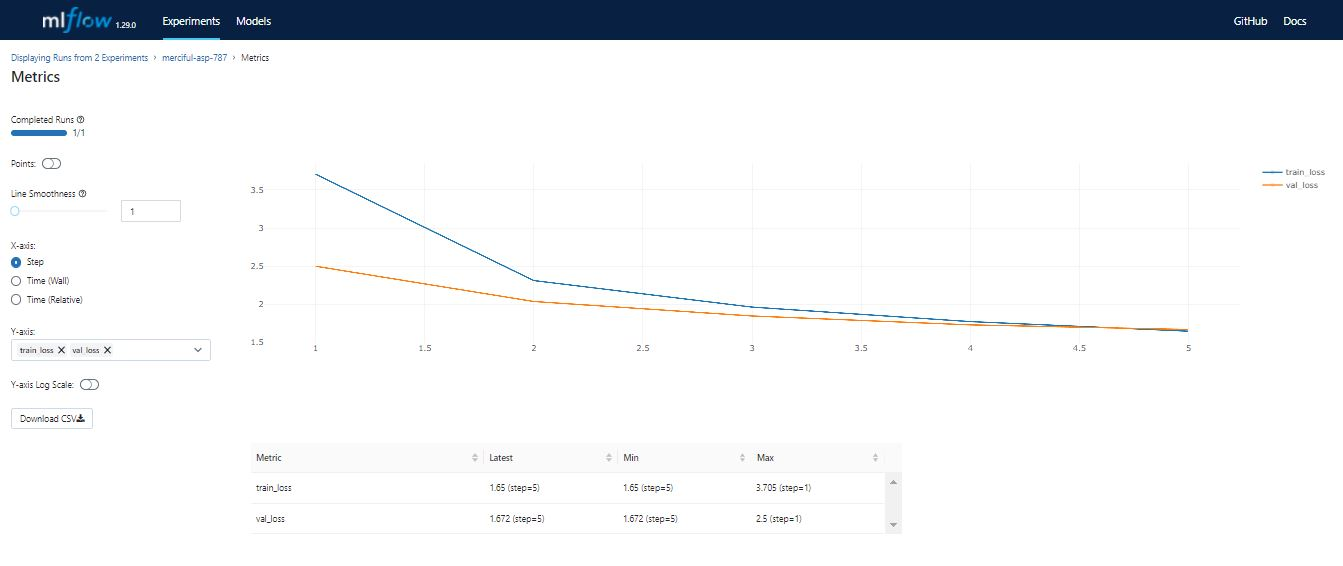

####Curva metrica (Balanced Accuracy)


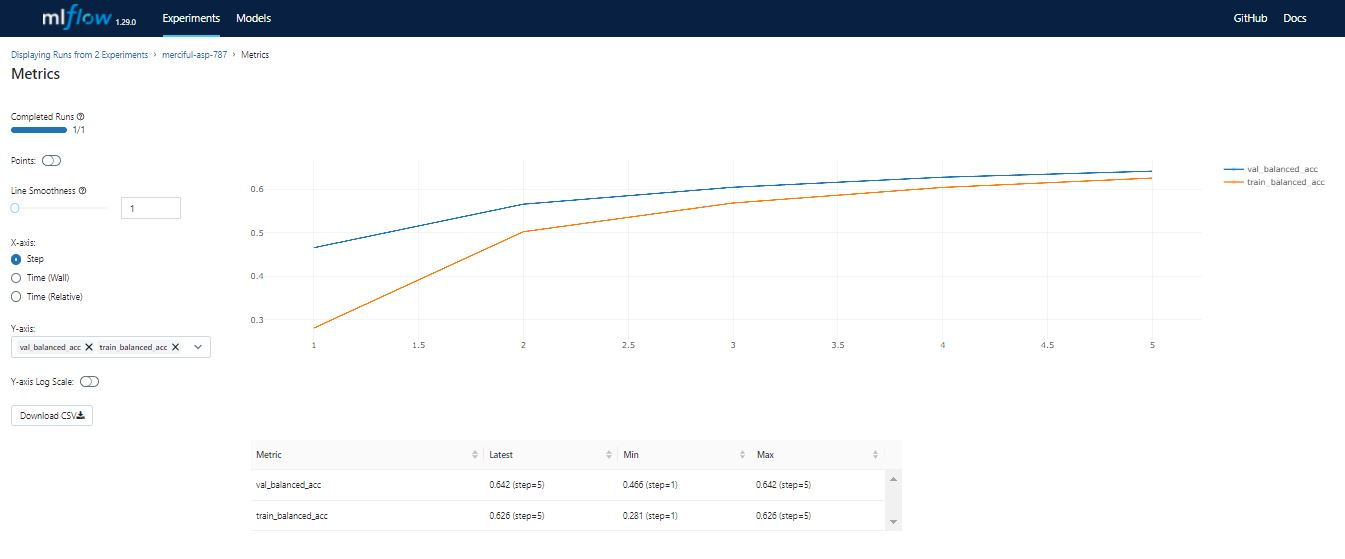

In [21]:
#180
mlflow.tracking.MlflowClient().list_experiments()

/tmp/ipykernel_3815061/2849051080.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  mlflow.tracking.MlflowClient().list_experiments()


[<Experiment: artifact_location='file:///users/wgremoliche/AprendizajeProfundo/mlruns/0', creation_time=1666739553990, experiment_id='0', last_update_time=1666739553990, lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///users/wgremoliche/AprendizajeProfundo/mlruns/3', creation_time=1667159760835, experiment_id='3', last_update_time=1667159760835, lifecycle_stage='active', name='Experiment_02_MLP', tags={}>]

In [22]:
#190
mlflow.search_runs().head(5)

,run_id,experiment_id,status,artifact_uri,start_time,end_time


In [23]:
#200
type(mlflow.search_runs())

pandas.core.frame.DataFrame

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
train_eval(neurons_h1=256, neurons_h2=1264,
           p_dropout=0.1, activation_fn=F.relu,
           opt=optim.Adam, lr=0.001, wd=0.00001,
           epochs=5, save_model=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4618676851823151


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5634182678240666


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6096712927734723


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6284543548868435


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6462477069822385


Predicciones sobre el set TEST
El conjunto test fue sometido al mismo preprocesamiento utilizado en las etapadas anteriores, teniendo en consideración que el diccionario es el formado a partir de los conjuntos de entrenamiento y evaluación porque el conjunto de prueba son datos "nuevos" que se presentan al modelo.

In [26]:
model = MLPTitleClassifier(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess.dictionary,
                        vector_size=300,
                        freeze_embedings=True,
                        activation_fn=F.relu,
                        neurons_h1=256,
                        neurons_h2=1264,
                        p_dropout=0.1)

In [27]:
#model.load_state_dict(torch.load('./data/MLPTitleClassifier_2022-10-22_16-47-03.pth'))
#model.load_state_dict(torch.load('./data/MLPTitleClassifier_2022-11-04_07-27-54.pth'))
model.load_state_dict(torch.load('./data/MLPTitleClassifier_2022-11-08_07-12-32.pth'))


<All keys matched successfully>

In [28]:
df_test = pd.read_json(f"./data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)
test_size = len(df_test)
batch_size = 128
pad_sequences = PadSequences()
test_dataset = MeLiChallengeDataset(df_test, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)

Predicciones

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [31]:

    
    
    
BATCHES_test = (int(test_size/batch_size) + (test_size % batch_size>0))
model.to(device)
model.eval()
targets = []
predictions = []
pbar = tqdm(test_loader, total=BATCHES_test)
with torch.no_grad():
    for idx, batch in enumerate(pbar):
        data = batch["data"].to(device)
        target = batch["target"].to(device)  
        output = model(data)
        targets.extend(target.cpu().numpy())
        predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
    metric = balanced_accuracy_score(targets, predictions)

print(f'Balanced accuracy TEST set: {metric}')

  0%|          | 0/498 [00:00<?, ?it/s]

Balanced accuracy TEST set: 0.7012129243413573


##PARTE 2: CNN

En esta seccion se presentan dos modelos con Redes Neuronales Convolucionales